In [1]:
import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
from collections import defaultdict 
import itertools as it
import networkx as nx
from networkx.algorithms.components.connected import connected_components as nx_connected_components
import pandas as pd
import pulp


# problem setup

In [2]:
# arbitrary large value used for linear programming hacks
# https://en.wikipedia.org/wiki/Big_M_method
big_M = 10**9


In [3]:
# surveyed taxa
taxa = ['a', 'b', 'c', 'd']


In [4]:
# pairwise hard UPPER bounds for MRCA generation
# (i.e., MRCA is AT or BEFORE these bounds)
# note that node names are generated by concatenation of sorted taxa
dist = {
    'ab' : 75,
    'ac' : 15,
    'bc' : 10,
    
    'ad' : 20,
    'bd' : 10,
    'cd' : 85,
}


In [5]:
# all possible pairings of taxa (i.e., distances in our distance matrix)
taxa_pairs = [''.join(sorted(pair)) for pair in it.combinations(taxa, 2)]
assert set(taxa_pairs) == set(dist.keys()), "mismatch between distance matrix and taxa"


In [6]:
model = pulp.LpProblem(name='MRCA_Inference', sense=pulp.LpMaximize)


# variable setup

In [7]:
mrca_dict = {}
obj_dict = {}
#input: two leaves
def get_mrca(a, b):
    key = frozenset((a, b))
    name = ''.join(sorted(key))
    if key not in mrca_dict:
        mrca_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=dist[name],
            cat=pulp.LpInteger,
        )
        obj_dict[key] = pulp.LpVariable(
            name + 'objective',
            lowBound=0,
            upBound=dist[name] - err[name],
            cat=pulp.LpInteger,
        )
    
    return mrca_dict[key]


In [8]:
lt_dict = {}
# input: two leaf-pairs
def get_lt(a, b):
    assert a != b
    if a > b:
        return get_gt(b, a)

    assert a < b
    key = frozenset((a, b))
    first, second = a, b
    name = f'{first}_lt_{second}'
    if key not in lt_dict:
        lt_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return lt_dict[key]


In [9]:
eq_dict = {}
# input: two leaf-pairs
def get_eq(a, b):
    assert a != b
    key = frozenset((a, b))
    first, second = sorted(key)
    name = f'{first}_eq_{second}'
    if key not in eq_dict:
        eq_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return eq_dict[key]


In [10]:
gt_dict = {}
# input: two leaf-pairs
def get_gt(a, b):
    assert a != b
    if a > b:
        return get_lt(b, a)

    assert a < b
    key = frozenset((a, b))
    first, second = a, b
    name = f'{first}_gt_{second}'
    if key not in gt_dict:
        gt_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return gt_dict[key]


# constraint setup

In [11]:
# set up pairwise MRCA generation comparison variables
for xx, yy in it.combinations(taxa_pairs, 2):
    # lookup (or generate) PuLP variables
    xx_mrca = get_mrca(*xx)
    yy_mrca = get_mrca(*yy)
    
    xx_eq_yy = get_eq(xx, yy)
    xx_lt_yy = get_lt(xx, yy)
    xx_gt_yy = get_gt(xx, yy)

    # lt, gt, and eq are mutually exclusive
    model += xx_lt_yy + xx_gt_yy + xx_eq_yy == 1

    # attach lt/gt to MRCA generation values
    model += -big_M * xx_lt_yy + xx_gt_yy <= (xx_mrca - yy_mrca)
    model += -big_M * xx_gt_yy + xx_lt_yy <= -(xx_mrca - yy_mrca)

# add node consolidation logic
# goal AB < AC ===> BC == AC  (if then statement)
# strategy: ab_lt_ac <= bc_eq_ac    
taxa_triplets = [*it.permutations(taxa, 3)]

for x, y, z in taxa_triplets:
    xy = ''.join(sorted([x, y]))
    xz = ''.join(sorted([x, z]))
    yz = ''.join(sorted([y, z]))
    
    # why isn't this get_lt?, is something backwards?
    model += get_gt(xy, xz) <= get_eq(yz, xz)


In [12]:
for key in mrca_dict:
    model += obj_dict[key] <= mrca_dict[key]

# optimization setup

In [12]:
# maximum likelihood comes from pushing generations of internal nodes as far forward as possible
model += sum(obj_dict.values())


# solve

In [13]:
model


MRCA_Inference:
MAXIMIZE
1*ab + 1*ac + 1*ad + 1*bc + 1*bd + 1*cd + 0
SUBJECT TO
_C1: ab_eq_ac + ab_gt_ac + ab_lt_ac = 1

_C2: - ab + ab_gt_ac - 1000000000 ab_lt_ac + ac <= 0

_C3: ab - 1000000000 ab_gt_ac + ab_lt_ac - ac <= 0

_C4: ab_eq_ad + ab_gt_ad + ab_lt_ad = 1

_C5: - ab + ab_gt_ad - 1000000000 ab_lt_ad + ad <= 0

_C6: ab - 1000000000 ab_gt_ad + ab_lt_ad - ad <= 0

_C7: ab_eq_bc + ab_gt_bc + ab_lt_bc = 1

_C8: - ab + ab_gt_bc - 1000000000 ab_lt_bc + bc <= 0

_C9: ab - 1000000000 ab_gt_bc + ab_lt_bc - bc <= 0

_C10: ab_eq_bd + ab_gt_bd + ab_lt_bd = 1

_C11: - ab + ab_gt_bd - 1000000000 ab_lt_bd + bd <= 0

_C12: ab - 1000000000 ab_gt_bd + ab_lt_bd - bd <= 0

_C13: ab_eq_cd + ab_gt_cd + ab_lt_cd = 1

_C14: - ab + ab_gt_cd - 1000000000 ab_lt_cd + cd <= 0

_C15: ab - 1000000000 ab_gt_cd + ab_lt_cd - cd <= 0

_C16: ac_eq_ad + ac_gt_ad + ac_lt_ad = 1

_C17: - ac + ac_gt_ad - 1000000000 ac_lt_ad + ad <= 0

_C18: ac - 1000000000 ac_gt_ad + ac_lt_ad - ad <= 0

_C19: ac_eq_bc + ac_gt_bc + a

In [14]:
model.solve()


1

In [15]:
pulp.LpStatus[model.status]


'Optimal'

# inspect results

In [16]:
for var in mrca_dict.values():
    print(var, var.varValue)


ab 75.0
ac 10.0
ad 10.0
bc 10.0
bd 10.0
cd 85.0


In [17]:
for key in lt_dict.keys():
    print(key)
    for var in lt_dict[key], eq_dict[key], gt_dict[key]:
        print('\t', var, var.varValue)


frozenset({'ab', 'ac'})
	 ab_lt_ac 0.0
	 ab_eq_ac 0.0
	 ab_gt_ac 1.0
frozenset({'ad', 'ab'})
	 ab_lt_ad 0.0
	 ab_eq_ad 0.0
	 ab_gt_ad 1.0
frozenset({'ab', 'bc'})
	 ab_lt_bc 0.0
	 ab_eq_bc 0.0
	 ab_gt_bc 1.0
frozenset({'ab', 'bd'})
	 ab_lt_bd 0.0
	 ab_eq_bd 0.0
	 ab_gt_bd 1.0
frozenset({'ab', 'cd'})
	 ab_lt_cd 1.0
	 ab_eq_cd 0.0
	 ab_gt_cd 0.0
frozenset({'ad', 'ac'})
	 ac_lt_ad 0.0
	 ac_eq_ad 1.0
	 ac_gt_ad 0.0
frozenset({'bc', 'ac'})
	 ac_lt_bc 0.0
	 ac_eq_bc 1.0
	 ac_gt_bc 0.0
frozenset({'ac', 'bd'})
	 ac_lt_bd 0.0
	 ac_eq_bd 1.0
	 ac_gt_bd 0.0
frozenset({'ac', 'cd'})
	 ac_lt_cd 1.0
	 ac_eq_cd 0.0
	 ac_gt_cd 0.0
frozenset({'ad', 'bc'})
	 ad_lt_bc 0.0
	 ad_eq_bc 1.0
	 ad_gt_bc 0.0
frozenset({'ad', 'bd'})
	 ad_lt_bd 0.0
	 ad_eq_bd 1.0
	 ad_gt_bd 0.0
frozenset({'ad', 'cd'})
	 ad_lt_cd 1.0
	 ad_eq_cd 0.0
	 ad_gt_cd 0.0
frozenset({'bc', 'bd'})
	 bc_lt_bd 0.0
	 bc_eq_bd 1.0
	 bc_gt_bd 0.0
frozenset({'bc', 'cd'})
	 bc_lt_cd 1.0
	 bc_eq_cd 0.0
	 bc_gt_cd 0.0
frozenset({'cd', 'bd'})
	 bd_lt_cd

# reconstruct


In [18]:
# step 1: consolidate internal nodes

gen_to_pair = defaultdict(set)
for k, v in mrca_dict.items():
    gen_to_pair[v.varValue].add(k)

internal_nodes = []
for gen, pairs in sorted(gen_to_pair.items(), key=lambda item: item[0], reverse=True):
    G = nx.from_edgelist(pairs)
    components = nx_connected_components(G)
    for component in components:
        internal_nodes.append((gen, component))

internal_nodes


[(85.0, {'c', 'd'}), (75.0, {'a', 'b'}), (10.0, {'a', 'b', 'c', 'd'})]

In [19]:
# step 2: join branches

# maps node names (leaves and internal) to unique integers
uid_generator = defaultdict(lambda: len(uid_generator))

consolidated_to = {
    taxum : taxum
    for taxum in taxa
}
records = []
for gen, internal_node in internal_nodes:
    name = ''.join(sorted(internal_node))

    stitched = {
        consolidated_to[leaf]
        for leaf in internal_node
    }
    for leaf in internal_node:
        consolidated_to[leaf] = name

    for stitch in stitched:  
        records.append({
            'id' : uid_generator[stitch],
            'id_' : stitch,
            'name' : stitch,
            'origin_time' : gen,
            'ancestor_list' : f'{[uid_generator[name]]}',
            'ancestor_list_' : f'{[name]}',
        })

records.append({
    'id' : uid_generator[''.join(sorted(internal_nodes[-1][1]))],
    'id_' : ''.join(sorted(internal_nodes[-1][1])),
    'name' : ''.join(sorted(internal_nodes[-1][1])),
    'origin_time' : 0,
    'ancestor_list' : f'{[]}',
    'ancestor_list_' : f'{[]}',
})


In [20]:
# load into pandas dataframe in alife standard format
df_phylogeny = pd.DataFrame.from_records(records)
df_phylogeny


,id,id_,name,origin_time,ancestor_list,ancestor_list_
0,0,c,c,85.0,[1],['cd']
1,2,d,d,85.0,[1],['cd']
2,3,a,a,75.0,[4],['ab']
3,5,b,b,75.0,[4],['ab']
4,4,ab,ab,10.0,[6],['abcd']
5,1,cd,cd,10.0,[6],['abcd']
6,6,abcd,abcd,0.0,[],[]


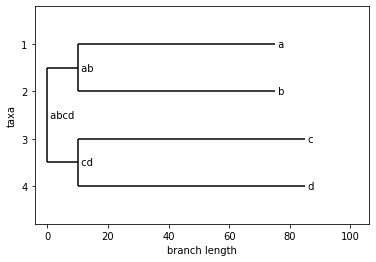

In [21]:
# convert to biopython and plot
tree = apc.alife_dataframe_to_biopython_tree(df_phylogeny, setup_branch_lengths=True)
tree.ladderize()
Phylo.draw(tree)
# note that origin_time isn't set quite correctly (off by one)
